In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2022],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39087 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 173 ms, sys: 52.4 ms, total: 225 ms
Wall time: 217 ms


# 2022 

In [5]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2022,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [6]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [7]:
first_size = get_ddf_shape(data[config_year.year])

In [8]:
data[config_year.year]

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,year_last_updated_date,month_last_updated_date,week_last_updated_date,dayofweek_last_updated_date,dayofmonth_last_updated_date,dayofyear_last_updated_date,hour_last_updated_date
npartitions=12,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Preprocessing

In [9]:
%%time

# do not execute everytime, takes 17s and eat the memory. Once executed disable the cell and restart the notebook. Since this cell saves a checkpoint you can continue without it.

data[config_year.year] = data[config_year.year].drop(['week_last_updated_date', 'traffic', 'last_reported'], axis=1)

data[config_year.year]['station_id']=data[config_year.year]['station_id'].astype(int)
data[config_year.year]['is_charging_station']=data[config_year.year]['is_charging_station'].astype(int)
data[config_year.year]['last_updated']=data[config_year.year]['last_updated'].astype(int)
data[config_year.year]['year_last_updated_date']=data[config_year.year]['year_last_updated_date'].astype(int)
data[config_year.year]['month_last_updated_date']=data[config_year.year]['month_last_updated_date'].astype(int)
data[config_year.year]['dayofweek_last_updated_date']=data[config_year.year]['dayofweek_last_updated_date'].astype(int)
data[config_year.year]['dayofmonth_last_updated_date']=data[config_year.year]['dayofmonth_last_updated_date'].astype(int)
data[config_year.year]['dayofyear_last_updated_date']=data[config_year.year]['dayofyear_last_updated_date'].astype(int)
data[config_year.year]['hour_last_updated_date']=data[config_year.year]['hour_last_updated_date'].astype(int)

data[config_year.year]['status']=data[config_year.year]['status'].round().astype(int)
data[config_year.year]['is_installed']=data[config_year.year]['is_installed'].round().astype(int)
data[config_year.year]['is_renting']=data[config_year.year]['is_renting'].round().astype(int)
data[config_year.year]['is_returning']=data[config_year.year]['is_returning'].round().astype(int)

# Found two station with alot of missing values 
# best solution is to remove
condition = (data[config_year.year]['station_id'].isin([520.0, 527.0, 532.0]))
data[config_year.year] = data[config_year.year].mask(condition, np.nan)
data[config_year.year] = data[config_year.year].dropna(subset=['station_id'])

last_size = get_ddf_shape(data[config_year.year])

new_columns = {
    'last_updated': 'timestamp',
    'year_last_updated_date':'year', 
    'month_last_updated_date':'month',
    'dayofweek_last_updated_date':'dayofweek', 
    'dayofmonth_last_updated_date':'day', 
    'dayofyear_last_updated_date':'dayofyear',
    'hour_last_updated_date':'hour'
}

data[config_year.year] = data[config_year.year].rename(columns=new_columns)

CPU times: user 1.46 s, sys: 75.7 ms, total: 1.53 s
Wall time: 3.45 s


In [10]:
save_checkpoint(data[config_year.year], config_year)

# checkpoint saved.
# CPU times: user 2.12 s, sys: 250 ms, total: 2.37 s
# Wall time: 17.3 s

checkpoint saved.


In [11]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 12.9 ms, sys: 1.13 ms, total: 14 ms
Wall time: 13.3 ms


In [12]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed -49 rows
dropped -3 columns
CPU times: user 119 ms, sys: 30.8 ms, total: 150 ms
Wall time: 932 ms


In [13]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [14]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 592 ms, sys: 109 ms, total: 701 ms
Wall time: 4.22 s


In [15]:
nans

{}

In [16]:
zeros

{'num_bikes_available': 2.5963585784636956,
 'num_bikes_available_types.mechanical': 15.926919084155319,
 'num_bikes_available_types.ebike': 15.558967110431807,
 'num_docks_available': 0.530128575792313,
 'is_charging_station': 2.254331416024464e-05,
 'status': 99.94682032189598,
 'is_installed': 0.00018034651328195712,
 'is_renting': 0.05944671944056512,
 'is_returning': 0.05944671944056512,
 'dayofweek': 14.206142827675524,
 'hour': 4.155116036073812}

In [17]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [18]:
uniques

{'station_id': 0        1
 1      380
 2       28
 3      379
 4      378
       ... 
 505     86
 506    314
 507     74
 508     66
 509    431
 Name: station_id, Length: 510, dtype: int64,
 'num_bikes_available': 0       18.000000
 1       17.166667
 2       14.875000
 3       12.636364
 4       12.111111
           ...    
 4812    39.153846
 4813    46.538462
 4814    47.461538
 4815    16.933333
 4816    20.458333
 Name: num_bikes_available, Length: 4817, dtype: float64,
 'num_bikes_available_types.mechanical': 0       12.000000
 1       11.166667
 2       12.375000
 3       12.454545
 4       11.222222
           ...    
 4141    45.846154
 4142    48.142857
 4143    18.944444
 4144    20.208333
 4145     7.208333
 Name: num_bikes_available_types.mechanical, Length: 4146, dtype: float64,
 'num_bikes_available_types.ebike': 0        6.000000
 1        2.500000
 2        0.181818
 3        0.111111
 4        1.000000
           ...    
 2737    30.636364
 2738    28.615385
 2739  

### Finding max capacity for a station

In [19]:
%%time

print(stats.describe(data[config_year.year].num_docks_available))
data[config_year.year].num_docks_available.describe().compute()

DescribeResult(nobs=4435905, minmax=(0.0, 54.0), mean=15.896243707356376, variance=64.74397115799614, skewness=0.19189554341309514, kurtosis=0.1070995253264142)
CPU times: user 573 ms, sys: 111 ms, total: 684 ms
Wall time: 2.24 s


count    4.435905e+06
mean     1.589624e+01
std      8.046364e+00
min      0.000000e+00
25%      1.112500e+01
50%      1.700000e+01
75%      2.211111e+01
max      5.400000e+01
Name: num_docks_available, dtype: float64

In [20]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=4435905, minmax=(0.0, 54.0), mean=9.337910827394044, variance=56.747394736976496, skewness=0.9777541557492114, kurtosis=1.0910584705337145)
CPU times: user 585 ms, sys: 95.7 ms, total: 680 ms
Wall time: 2.35 s


count    4.435905e+06
mean     9.337911e+00
std      7.533087e+00
min      0.000000e+00
25%      4.625000e+00
50%      1.000000e+01
75%      1.600000e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

In [21]:
%%time

print(stats.describe(data[config_year.year]['num_bikes_available_types.mechanical']))
data[config_year.year]['num_bikes_available_types.mechanical'].describe().compute()

DescribeResult(nobs=4435905, minmax=(0.0, 53.5), mean=6.66895148262246, variance=46.33574456210898, skewness=1.181808403304697, kurtosis=1.414315846810867)
CPU times: user 505 ms, sys: 109 ms, total: 613 ms
Wall time: 2.15 s


count    4.435905e+06
mean     6.668951e+00
std      6.807036e+00
min      0.000000e+00
25%      1.888889e+00
50%      6.285714e+00
75%      1.200000e+01
max      5.350000e+01
Name: num_bikes_available_types.mechanical, dtype: float64

In [22]:
print(stats.describe(data[config_year.year]['num_bikes_available_types.ebike']))
data[config_year.year]['num_bikes_available_types.ebike'].describe().compute()

DescribeResult(nobs=4435905, minmax=(0.0, 37.0), mean=2.675881389568528, variance=12.782052664047422, skewness=2.344050161467732, kurtosis=6.863610672271788)


count    4.435905e+06
mean     2.675881e+00
std      3.575200e+00
min      0.000000e+00
25%      5.833333e-01
50%      2.000000e+00
75%      5.333333e+00
max      3.700000e+01
Name: num_bikes_available_types.ebike, dtype: float64

correct data 4422894 incorrect data 13011
CPU times: user 1.58 s, sys: 284 ms, total: 1.86 s
Wall time: 6.67 s


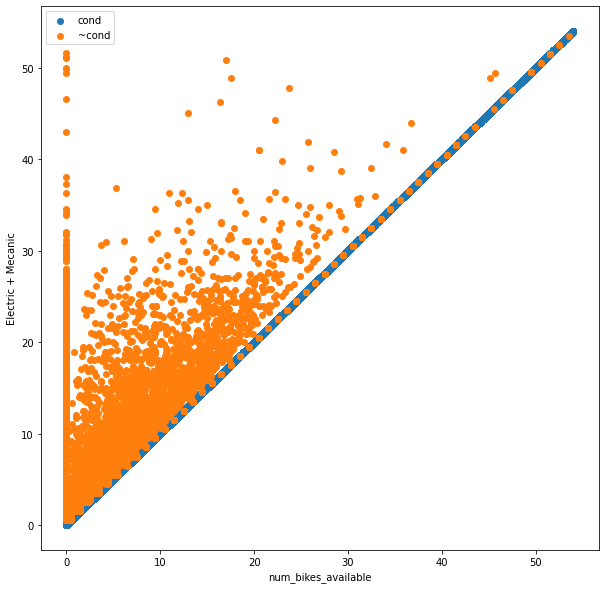

In [23]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())
    
plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [24]:
%%time

data[config_year.year]['num_bikes_available'] = data[config_year.year]['num_bikes_available'].mask(~cond, (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']))


CPU times: user 11.6 ms, sys: 176 µs, total: 11.8 ms
Wall time: 10.8 ms


correct data 4435905 incorrect data 0
CPU times: user 1.92 s, sys: 277 ms, total: 2.2 s
Wall time: 7.31 s


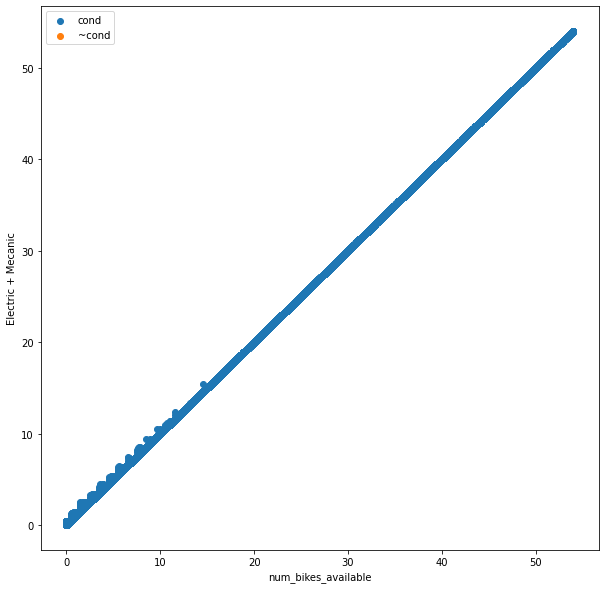

In [25]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())

plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [26]:
# Now capacity of a station must be something similar to the sum of available bikes and available docks

In [27]:
%%time

data[config_year.year]['capacity'] = data[config_year.year].num_bikes_available + data[config_year.year].num_docks_available

stations_max_capacity = data[config_year.year].groupby(['station_id'])['capacity'].max().reset_index()

# drop capacity 
data[config_year.year] = data[config_year.year].drop(['capacity'], axis=1)

# merge with stations_max_capacity
data[config_year.year] = data[config_year.year].merge(stations_max_capacity.copy(), how='left', on=['station_id'])


CPU times: user 29.4 ms, sys: 0 ns, total: 29.4 ms
Wall time: 28.6 ms


In [28]:
%%time

print(stats.describe(data[config_year.year]['capacity']))
data[config_year.year]['capacity'].describe().compute()

DescribeResult(nobs=4435905, minmax=(12.000000000000004, 54.00000000000003), mean=27.03854343138548, variance=39.64353039128416, skewness=1.2612521947969058, kurtosis=3.53609118042234)
CPU times: user 743 ms, sys: 205 ms, total: 948 ms
Wall time: 3.3 s


count    4.435905e+06
mean     2.703854e+01
std      6.296311e+00
min      1.200000e+01
25%      2.400000e+01
50%      2.700000e+01
75%      2.900000e+01
max      5.400000e+01
Name: capacity, dtype: float64

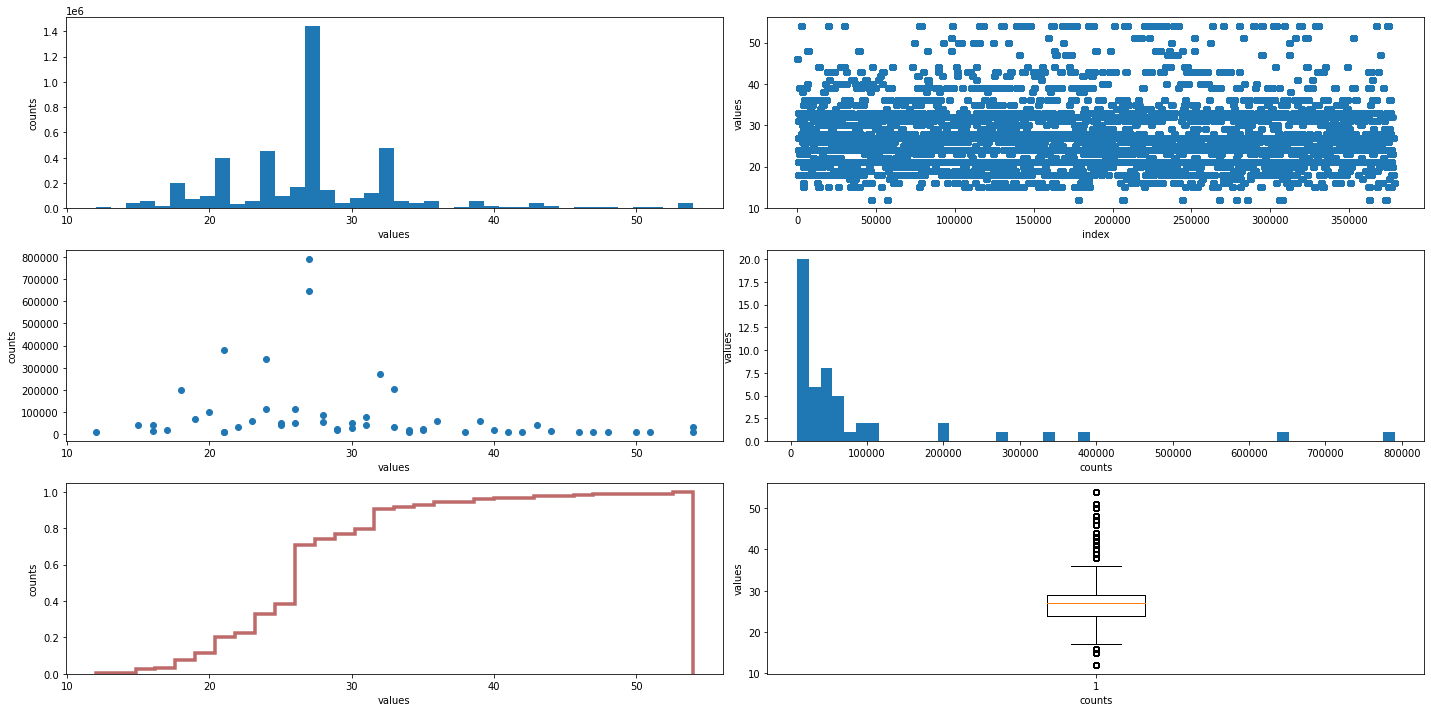

CPU times: user 6.82 s, sys: 1.16 s, total: 7.98 s
Wall time: 7.83 s


In [29]:
%%time

show_counts(data[config_year.year]['capacity'].compute())

## find the percentage of docks available

In [30]:
%%time

data[config_year.year]['ctx0'] = data[config_year.year].num_docks_available / data[config_year.year].capacity


CPU times: user 7.65 ms, sys: 0 ns, total: 7.65 ms
Wall time: 7.25 ms


In [31]:
%%time

print(stats.describe(data[config_year.year]['ctx0']))
data[config_year.year]['ctx0'].describe().compute()

DescribeResult(nobs=4435905, minmax=(0.0, 0.9999999999999998), mean=0.5863479099312545, variance=0.0682514692259674, skewness=-0.4632765701936975, kurtosis=-0.7679429472577799)
CPU times: user 794 ms, sys: 130 ms, total: 924 ms
Wall time: 3.16 s


count    4.435905e+06
mean     5.863479e-01
std      2.612498e-01
min      0.000000e+00
25%      4.444444e-01
50%      6.666667e-01
75%      8.218182e-01
max      1.000000e+00
Name: ctx0, dtype: float64

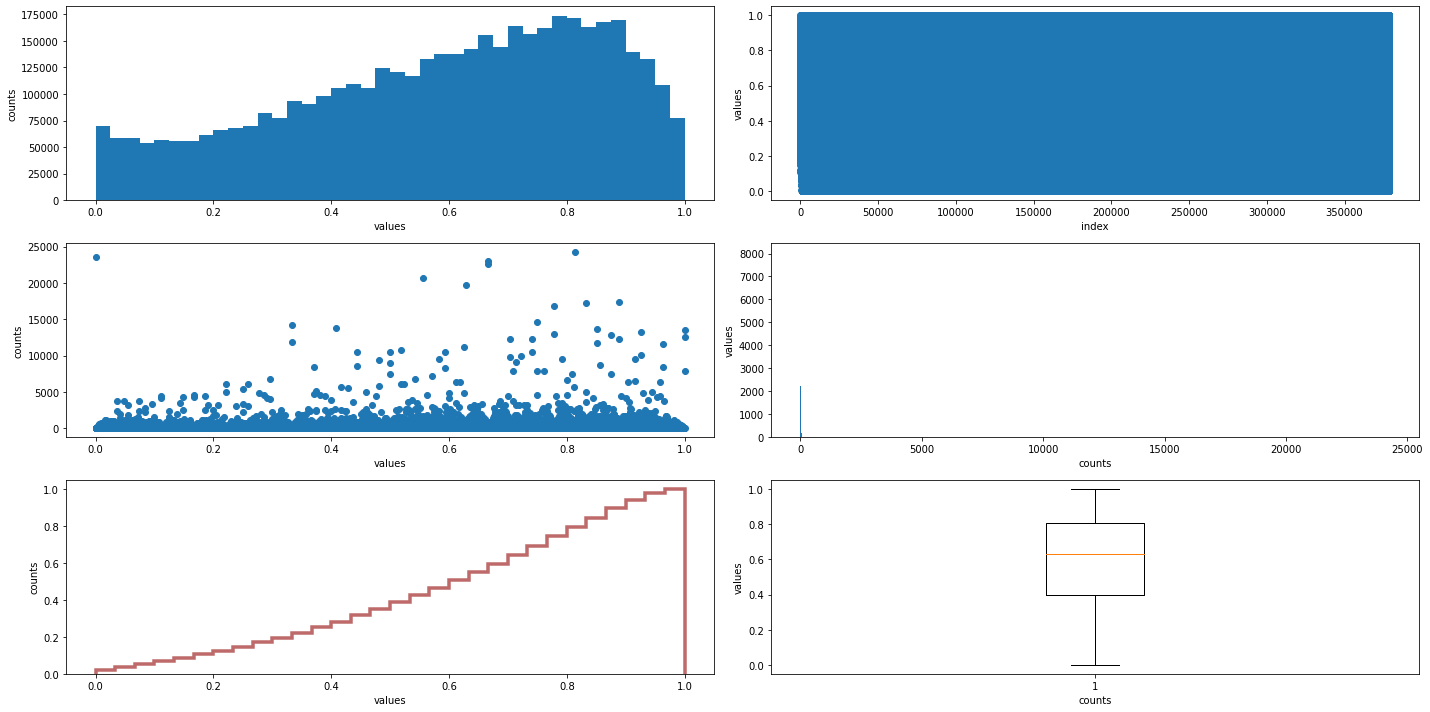

CPU times: user 1min 18s, sys: 12.4 s, total: 1min 30s
Wall time: 1min 28s


In [32]:
%%time

show_counts(data[config_year.year]['ctx0'].compute())

### Generating new columns of past 4 hours

In [33]:
%%time

ctx = data[config_year.year][['station_id', 'timestamp', 'ctx0']].copy()
# ctx = ctx.rename(columns={'num_docks_available': 'ctx0'})
print(ctx.columns)

for i in range(1,5): 
    ctx = ctx.rename(columns={f'ctx{i-1}': f'ctx{i}'})
    print(ctx.columns)
    
    ctx.timestamp = ctx.timestamp + 3600 
    data[config_year.year] = data[config_year.year].merge(ctx.copy(), how='left', on=['station_id','timestamp'])
    
    cond = data[config_year.year][f'ctx{i}'].isna()
    data[config_year.year][f'ctx{i}'] = data[config_year.year][f'ctx{i}'].mask(cond, data[config_year.year][f'ctx{i-1}'])


Index(['station_id', 'timestamp', 'ctx0'], dtype='object')
Index(['station_id', 'timestamp', 'ctx1'], dtype='object')
Index(['station_id', 'timestamp', 'ctx2'], dtype='object')
Index(['station_id', 'timestamp', 'ctx3'], dtype='object')
Index(['station_id', 'timestamp', 'ctx4'], dtype='object')
CPU times: user 163 ms, sys: 19.6 ms, total: 183 ms
Wall time: 178 ms


In [34]:
data[config_year.year].columns

Index(['station_id', 'num_bikes_available',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_charging_station', 'status', 'is_installed', 'is_renting',
       'is_returning', 'timestamp', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [35]:
%%time

get_features_nans(data[config_year.year])

CPU times: user 11.7 s, sys: 489 ms, total: 12.2 s
Wall time: 27.2 s


{}

In [36]:
%%time

save_checkpoint(data[config_year.year], config_year)

# checkpoint saved.

checkpoint saved.
CPU times: user 3.9 s, sys: 302 ms, total: 4.2 s
Wall time: 32 s
